In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from ApiClient import ApiClient
api_client = ApiClient()

startDate = '2020-12-20'
endDate = '2025-06-13'
base_symbol= {"name":"SP500","symbol":"^GSPC"}


In [42]:
fearAndGreed_df=pd.read_csv('./datasets/fearAndGreed.csv', sep=',')
data_df = fearAndGreed_df
vix= pd.read_csv('./datasets/vixHistoryData.csv', sep=',')
data_df = data_df.merge(
    vix,
    on='Date',
    how='left'
)


codeBaseSymbol, baseSymbolData = api_client.get("getIndexHistory", {'tickerSymbol':base_symbol['symbol']})

if codeBaseSymbol == 0:
    baseSymbolData = pd.DataFrame(baseSymbolData)
    baseSymbolData['Date'] = pd.to_datetime(baseSymbolData['Date'], unit='ms')
    baseSymbolData = baseSymbolData[
        (baseSymbolData['Date'] >= pd.Timestamp(startDate)) &
        (baseSymbolData['Date'] <= pd.Timestamp(endDate))
    ]
    baseSymbolData['Date'] = baseSymbolData['Date'].dt.strftime('%Y-%m-%d')
    baseSymbolData['log_r'] = np.log(baseSymbolData['Close'] / baseSymbolData['Close'].shift(1))
    baseSymbolData['log_r'].iloc[0] = 0
    baseSymbolData['Index'] = 100 * np.exp(baseSymbolData['log_r'].cumsum())
    baseSymbolData = baseSymbolData.drop(columns=['log_r'])
    #baseSymbolData = baseSymbolData.rename(columns={'Index': 'Close'})
    data_df = data_df.merge(
        baseSymbolData[['Date', 'Index']],
        on='Date',
        how='left'
    )
    data_df = data_df.dropna(subset=['Index'])
else:
    print("Error fetching base symbol history data:", codeBaseSymbol, baseSymbolData)

C:\Users\nunor\AppData\Local\Temp\ipykernel_91328\3554940650.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  baseSymbolData['log_r'].iloc[0] = 0
C:\Users\nunor\AppData\Local\Temp\ipykernel_91328\3554940650.py:22: SettingWithCopyWarning:

In [43]:
print(baseSymbolData)

             Date         Open         High          Low        Close  \
19857  2020-12-21  3684.280029  3702.899902  3636.479980  3694.919922   
19858  2020-12-22  3698.080078  3698.260010  3676.159912  3687.260010   
19859  2020-12-23  3693.419922  3711.239990  3689.280029  3690.010010   
19860  2020-12-24  3694.030029  3703.820068  3689.320068  3703.060059   
19861  2020-12-28  3723.030029  3740.510010  3723.030029  3735.360107   
...           ...          ...          ...          ...          ...   
20977  2025-06-09  6004.629883  6021.310059  5994.180176  6005.879883   
20978  2025-06-10  6009.910156  6043.009766  6000.279785  6038.810059   
20979  2025-06-11  6049.379883  6059.399902  6002.319824  6022.240234   
20980  2025-06-12  6009.899902  6045.430176  6003.879883  6045.259766   
20981  2025-06-13  6000.560059  6026.160156  5963.209961  5976.970215   

             Volume     adjclose  Stock Splits  Dividends       Index  
19857  4.748580e+09  3694.919922             0     

In [44]:
print(data_df)
print("Number of NA values in SP500:", data_df['Index'].isna().sum())

            Date  FearGreed        VIX       Index
2509  2020-12-21  63.000000  25.160000  100.000000
2510  2020-12-22  59.000000  24.230000   99.792691
2511  2020-12-23  57.000000  23.309999   99.867117
2512  2020-12-24  54.000000  21.530001  100.220306
2513  2020-12-28  54.000000  21.700001  101.094481
...          ...        ...        ...         ...
3634  2025-06-09  61.771429  17.160000  162.544250
3635  2025-06-10  63.600000  16.950001  163.435479
3636  2025-06-11  61.657143  17.260000  162.987030
3637  2025-06-12  60.114286  18.020000  163.610035
3638  2025-06-13  59.885714  20.820000  161.761834

[1125 rows x 4 columns]
Number of NA values in SP500: 0


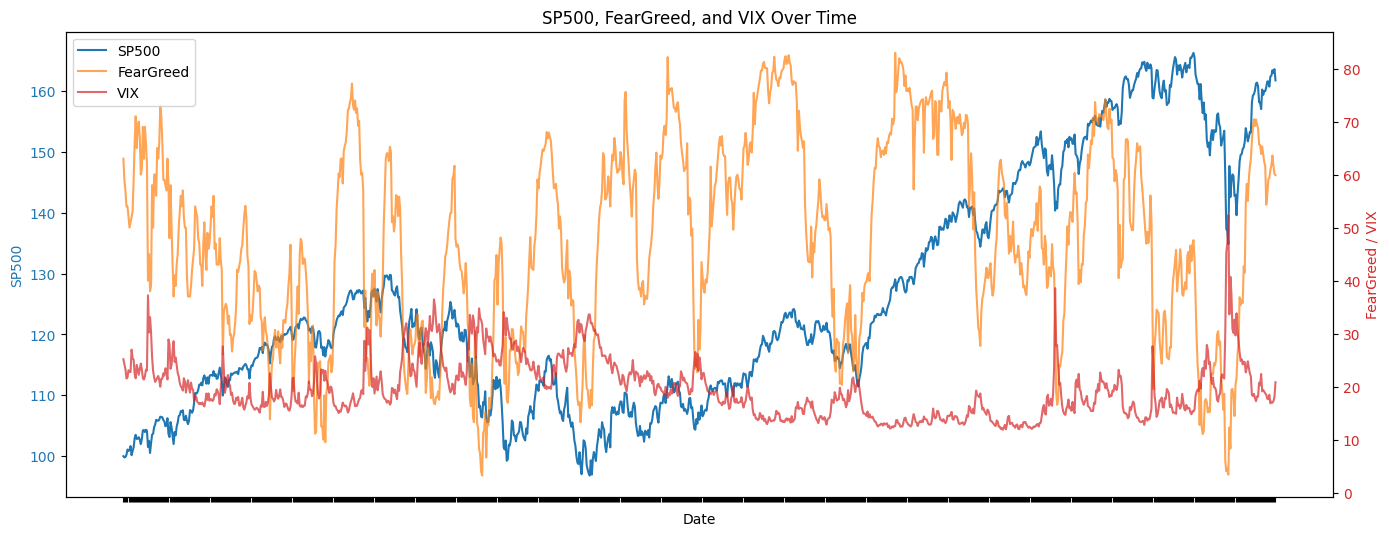

In [45]:

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('SP500', color='tab:blue')
ax1.plot(data_df['Date'], data_df['Index'], color='tab:blue', label='SP500')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Remove x-axis tick labels
ax1.set_xticklabels([])

ax2 = ax1.twinx()
ax2.set_ylabel('FearGreed / VIX', color='tab:red')
ax2.plot(data_df['Date'], data_df['FearGreed'], color='tab:orange', label='FearGreed', alpha=0.7)
ax2.plot(data_df['Date'], data_df['VIX'], color='tab:red', label='VIX', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.set_xticklabels([])

fig.tight_layout()
fig.autofmt_xdate()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('SP500, FearGreed, and VIX Over Time')
plt.show()

In [46]:
data_df['FearGreed'] = (data_df['FearGreed'] - data_df['FearGreed'].min()) / (data_df['FearGreed'].max() - data_df['FearGreed'].min())

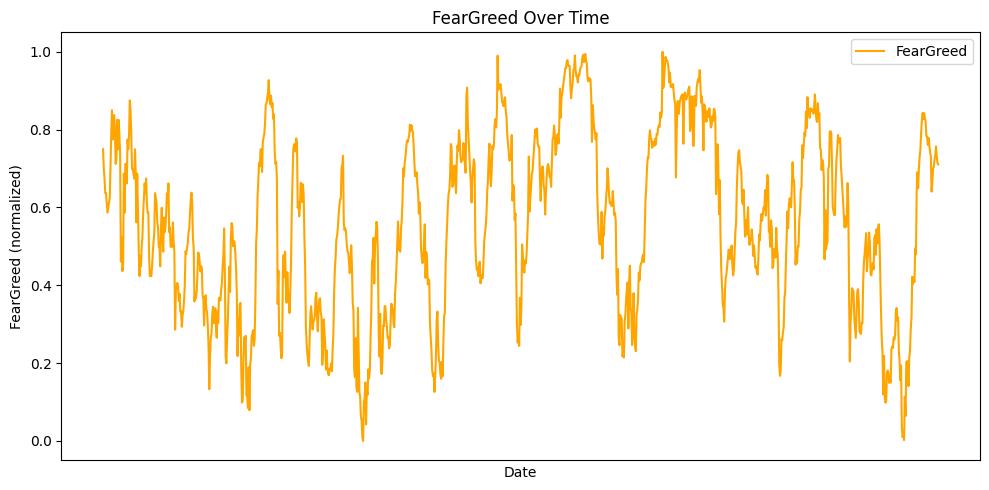

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(data_df['Date'], data_df['FearGreed'], color='orange', label='FearGreed')
plt.xlabel('Date')
plt.ylabel('FearGreed (normalized)')
plt.title('FearGreed Over Time')
plt.legend()
plt.xticks([], [])  # Hide x-axis tick labels for clarity
plt.tight_layout()
plt.show()

In [48]:
VIXma1=3
VIXma2=10
data_df['VIX'] = (data_df['VIX'] - data_df['VIX'].min()) / (data_df['VIX'].max() - data_df['VIX'].min())
data_df['VIXma1'] = data_df['VIX'].rolling(window=VIXma1).mean()
data_df['VIXma2'] = data_df['VIX'].rolling(window=VIXma2).mean()
data_df['VIXratio'] = data_df['VIXma1'] / data_df['VIXma2']
data_df = data_df.drop(columns=['VIX','VIXma1', 'VIXma2'])
data_df = data_df.iloc[VIXma2:]
data_df = data_df.rename(columns={'VIXratio': 'VIX'})

In [49]:
print(data_df)
print("Number of NA values in VIX:", data_df['VIX'].isna().sum())

            Date  FearGreed       Index       VIX
2519  2021-01-06   0.699511  101.440355  1.179292
2520  2021-01-07   0.787263  102.946481  1.066300
2521  2021-01-08   0.849944  103.511849  0.972586
2522  2021-01-11   0.774727  102.833355  0.923221
2523  2021-01-12   0.824872  102.876112  0.937500
...          ...        ...         ...       ...
3634  2025-06-09   0.734254  162.544250  0.882476
3635  2025-06-10   0.757177  163.435479  0.831575
3636  2025-06-11   0.732821  162.987030  0.884148
3637  2025-06-12   0.713480  163.610035  0.948394
3638  2025-06-13   0.710614  161.761834  1.127782

[1115 rows x 4 columns]
Number of NA values in VIX: 0


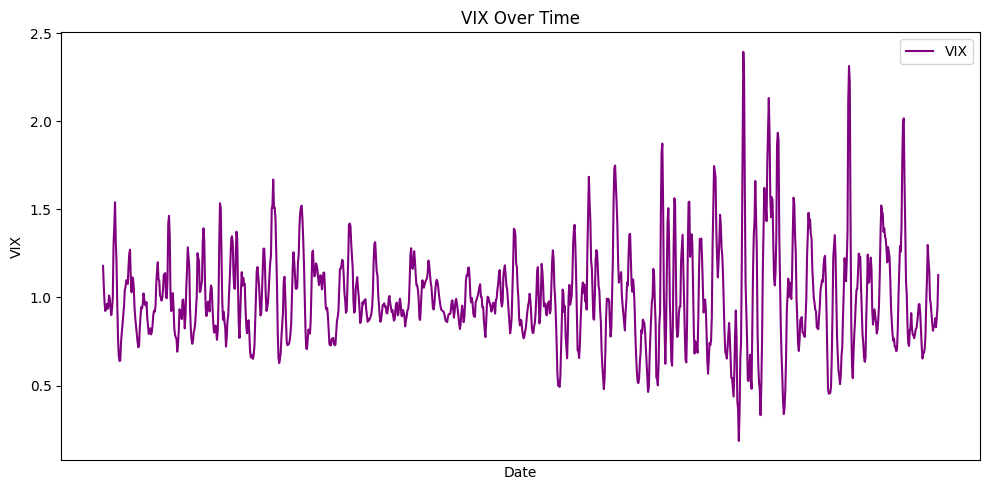

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(data_df['Date'], data_df['VIX'], color='purple', label='VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('VIX Over Time')
plt.legend()
plt.xticks([], [])  # Hide x-axis tick labels for clarity
plt.tight_layout()
plt.show()

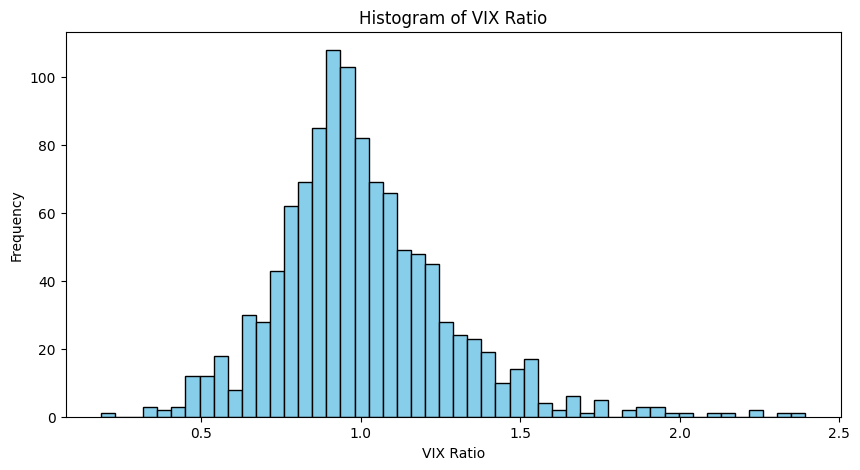

In [51]:


plt.figure(figsize=(10, 5))
plt.hist(data_df['VIX'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.xlabel('VIX Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of VIX Ratio')
plt.show()

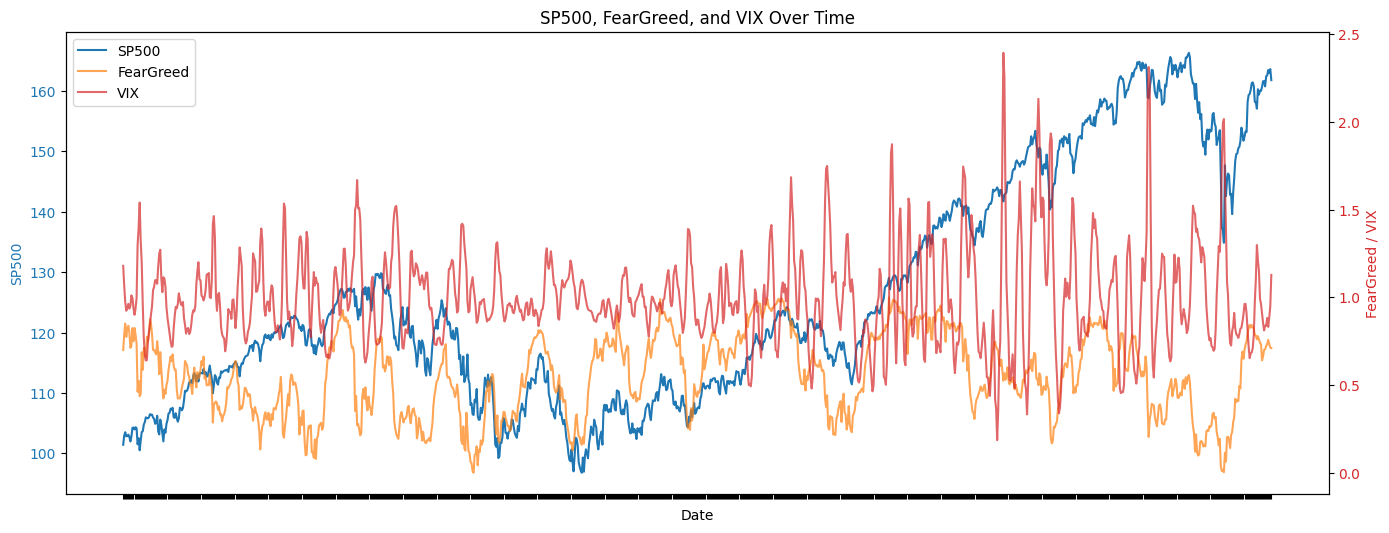

In [52]:

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('SP500', color='tab:blue')
ax1.plot(data_df['Date'], data_df['Index'], color='tab:blue', label='SP500')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Remove x-axis tick labels
ax1.set_xticklabels([])

ax2 = ax1.twinx()
ax2.set_ylabel('FearGreed / VIX', color='tab:red')
ax2.plot(data_df['Date'], data_df['FearGreed'], color='tab:orange', label='FearGreed', alpha=0.7)
ax2.plot(data_df['Date'], data_df['VIX'], color='tab:red', label='VIX', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')

ax2.set_xticklabels([])

fig.tight_layout()
fig.autofmt_xdate()
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('SP500, FearGreed, and VIX Over Time')
plt.show()

In [53]:
print(data_df)

            Date  FearGreed       Index       VIX
2519  2021-01-06   0.699511  101.440355  1.179292
2520  2021-01-07   0.787263  102.946481  1.066300
2521  2021-01-08   0.849944  103.511849  0.972586
2522  2021-01-11   0.774727  102.833355  0.923221
2523  2021-01-12   0.824872  102.876112  0.937500
...          ...        ...         ...       ...
3634  2025-06-09   0.734254  162.544250  0.882476
3635  2025-06-10   0.757177  163.435479  0.831575
3636  2025-06-11   0.732821  162.987030  0.884148
3637  2025-06-12   0.713480  163.610035  0.948394
3638  2025-06-13   0.710614  161.761834  1.127782

[1115 rows x 4 columns]


In [54]:
print(baseSymbolData)

             Date         Open         High          Low        Close  \
19857  2020-12-21  3684.280029  3702.899902  3636.479980  3694.919922   
19858  2020-12-22  3698.080078  3698.260010  3676.159912  3687.260010   
19859  2020-12-23  3693.419922  3711.239990  3689.280029  3690.010010   
19860  2020-12-24  3694.030029  3703.820068  3689.320068  3703.060059   
19861  2020-12-28  3723.030029  3740.510010  3723.030029  3735.360107   
...           ...          ...          ...          ...          ...   
20977  2025-06-09  6004.629883  6021.310059  5994.180176  6005.879883   
20978  2025-06-10  6009.910156  6043.009766  6000.279785  6038.810059   
20979  2025-06-11  6049.379883  6059.399902  6002.319824  6022.240234   
20980  2025-06-12  6009.899902  6045.430176  6003.879883  6045.259766   
20981  2025-06-13  6000.560059  6026.160156  5963.209961  5976.970215   

             Volume     adjclose  Stock Splits  Dividends       Index  
19857  4.748580e+09  3694.919922             0     

In [55]:
exportFolder = './processedDatasets'
#finalStartDate = '2021-01-01'


#baseSymbolData['Date'] = pd.to_datetime(baseSymbolData['Date'])
#baseSymbolData = baseSymbolData[
#    (baseSymbolData['Date'] >= pd.Timestamp(finalStartDate)) 
#]
#baseSymbolData['Date'] = baseSymbolData['Date'].dt.strftime('%Y-%m-%d')
#data_df['Date'] = pd.to_datetime(data_df['Date'])
#data_df = data_df[
#    (data_df['Date'] >= pd.Timestamp(finalStartDate)) 
#]
#data_df['Date'] = data_df['Date'].dt.strftime('%Y-%m-%d')

exportVix = data_df[['Date', 'VIX']].copy()
exportVix.to_csv('./processedDatasets/vixHistoryData.csv', index=False, sep=',', decimal='.')
fearAndGreedExport = data_df[['Date', 'FearGreed']].copy()
fearAndGreedExport.to_csv('./processedDatasets/fearAndGreed.csv', index=False, sep=',', decimal='.')

combinedData = baseSymbolData.merge(data_df[['Date','FearGreed','VIX']], on='Date', how='left')
combinedData = combinedData[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'FearGreed', 'VIX']]
combinedData = combinedData.iloc[VIXma2:]

# Export combined data
combinedData.to_csv('./processedDatasets/combinedData.csv', index=False, sep=',', decimal='.')

In [47]:
low_fear_greed_days = data_df[data_df['FearGreed'] < 0.05]
print(low_fear_greed_days[['Date', 'FearGreed']])

            Date  FearGreed
147   2011-08-03   0.020619
150   2011-08-08   0.010309
151   2011-08-09   0.020619
152   2011-08-10   0.020619
153   2011-08-11   0.030928
943   2014-10-02   0.030928
947   2014-10-08   0.041237
948   2014-10-09   0.030928
949   2014-10-10   0.010309
950   2014-10-13   0.000000
951   2014-10-14   0.020619
952   2014-10-15   0.010309
953   2014-10-16   0.020619
1167  2015-08-24   0.030928
2006  2018-12-21   0.030928
2007  2018-12-24   0.020619
2008  2018-12-26   0.041237
2309  2020-03-09   0.030928
2311  2020-03-11   0.041237
2312  2020-03-12   0.020619
2314  2020-03-16   0.030928
2862  2022-05-11   0.041546
2863  2022-05-12   0.032990
3589  2025-04-04   0.041221
3590  2025-04-07   0.046737
3591  2025-04-08   0.034908


In [49]:
high_fear_greed_days = data_df[data_df['FearGreed'] > 0.95]
print(high_fear_greed_days[['Date', 'FearGreed']])

            Date  FearGreed
429   2012-09-14   0.958763
433   2012-09-20   0.958763
434   2012-09-21   0.958763
519   2013-01-28   0.958763
520   2013-01-29   0.969072
521   2013-01-30   0.958763
869   2014-06-18   0.969072
870   2014-06-19   0.979381
871   2014-06-20   0.979381
872   2014-06-23   0.958763
1701  2017-10-05   0.979381
2260  2019-12-26   0.958763
2263  2019-12-31   0.958763
2264  2020-01-02   1.000000
2265  2020-01-03   0.958763
2266  2020-01-06   0.958763
2269  2020-01-09   0.958763
